In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn.decomposition import NMF
from sklearn.model_selection import StratifiedKFold, ParameterGrid, KFold
from sklearn.preprocessing import minmax_scale
from activ.readfile import TrackTBIFile
import numpy as np

import scipy.stats as sps
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
def nmf_bic(X, nmf):
    var = np.diag(X.var(axis=0)) + np.identity(X.shape[1])*0.001
    mu = nmf.inverse_transform(nmf.transform(X))
    logL = 0.0
    for i in range(X.shape[0]):
        logL += np.log(sps.multivariate_normal(mean=mu[i], cov=var).pdf(X[i]))
    k = np.prod(nmf.components_.shape)
    n = X.shape[0] 
    return k*np.log(n) - 2*logL

def recon_err(X, nmf):
    X_recon = nmf.inverse_transform(nmf.transform(X))
    return np.linalg.norm(X_recon - X, ord='fro')

def tbi_cv_gridsearch(X, gcs_simple, n_splits=5, ranks=np.arange(4, 40), scorer=recon_err):
    cv = StratifiedKFold(n_splits)
    ret = np.zeros((cv.n_splits, ranks.shape[0]))
    for i, (train_idx, test_idx) in enumerate(cv.split(X, gcs_simple)):
        X_train, X_test = X[train_idx], X[test_idx]
        for j, k in enumerate(ranks):
            nmf = NMF(n_components=k, solver='mu', beta_loss='kullback-leibler', init='random').fit(X_train)
            ret[i, j] = scorer(X_test, nmf)
    return ret

In [3]:
default_ranks = np.arange(4, 15)
def tbi_gridsearch(X, ranks=default_ranks, scorer=recon_err, rs=10001):
    ret = np.zeros(ranks.shape[0])
    for j, k in enumerate(ranks):
        nmf = NMF(n_components=k, solver='mu', beta_loss='kullback-leibler', init='random', random_state=rs).fit(X)
        ret[j] = scorer(X, nmf)
    return ret

In [4]:
tbifile = TrackTBIFile('../../tracktbi.scalar.h5')

In [35]:
bm_results = tbi_gridsearch(minmax_scale(tbifile.biomarkers), scorer=nmf_bic, rs=2005)

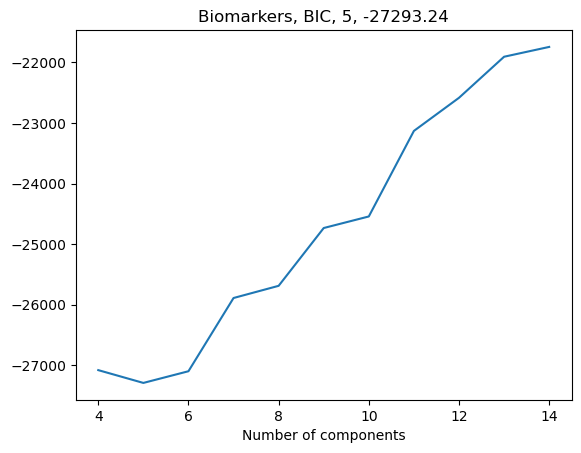

In [36]:
plt.plot(default_ranks, bm_results)
idx = np.argmin(bm_results)
plt.title('Biomarkers, BIC, %d, %0.2f' % (default_ranks[idx], bm_results[idx]))
plt.xlabel('Number of components')
plt.savefig('biomarkers_bic.2.png')

In [37]:
oc_results = tbi_gridsearch(minmax_scale(tbifile.outcomes), scorer=nmf_bic, rs=2009)

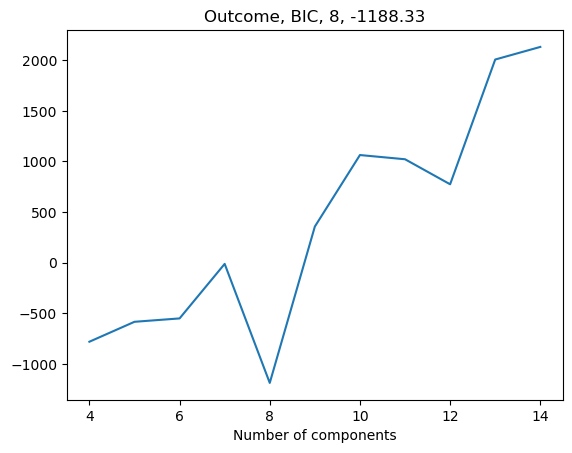

In [38]:
plt.plot(default_ranks, oc_results)
idx = np.argmin(oc_results)
plt.title('Outcome, BIC, %d, %0.2f' % (default_ranks[idx], oc_results[idx]))
plt.xlabel('Number of components')
plt.savefig('outcomes_bic.2.png')

In [9]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

5 -27293.237523163505 915.5838865259482
8 -1188.329849273574 547.7923184349546


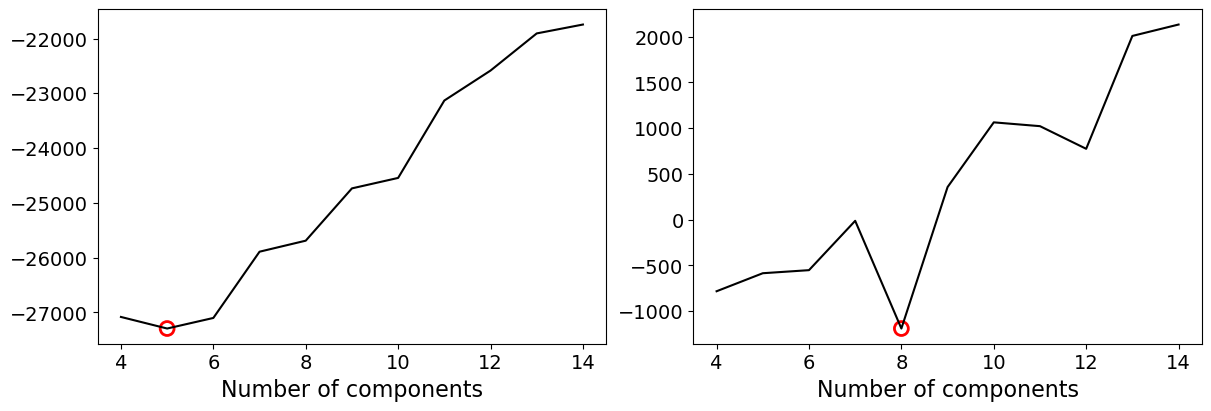

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
for _ax in axes:
    _ax.tick_params('both', labelsize=14)

def add_arrow(ax, x, y):
    mn, mx = ax.get_ylim()
    dy = 0.15 * (mx - mn)
    print(x, y, dy)
    # ax.arrow(x, y+dy*1.1, 0, -dy, shape='full', width=)
    # ax.annotate("", xy=(x, y), xytext=(x, y+dy*1.1), arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
    ax.scatter(x, y, facecolor='none', color='red', s=100, linewidth=2)


axes[0].plot(default_ranks, bm_results, c='k')
idx = np.argmin(bm_results)
#plt.title('Biomarkers, BIC, %d, %0.2f' % (default_ranks[idx], bm_results[idx]))
#axes[0].set_title('Biomarkers, BIC, %d' % (default_ranks[idx]), fontsize=16)
axes[0].set_xlabel('Number of components', fontsize=16)
add_arrow(axes[0], default_ranks[idx], bm_results[idx])


axes[1].plot(default_ranks, oc_results, c='k')
idx = np.argmin(oc_results)
#plt.title('Outcome, BIC, %d, %0.2f' % (default_ranks[idx], oc_results[idx]))
#axes[1].set_title('Outcome, BIC, %d' % (default_ranks[idx]), fontsize=16)
axes[1].set_xlabel('Number of components', fontsize=16)
add_arrow(axes[1], default_ranks[idx], oc_results[idx])

plt.savefig('nmf_bic.png', dpi=100)

In [11]:
from sklearn.decomposition import PCA
bm_pca = PCA().fit(tbifile.biomarkers)
oc_pca = PCA().fit(tbifile.outcomes)

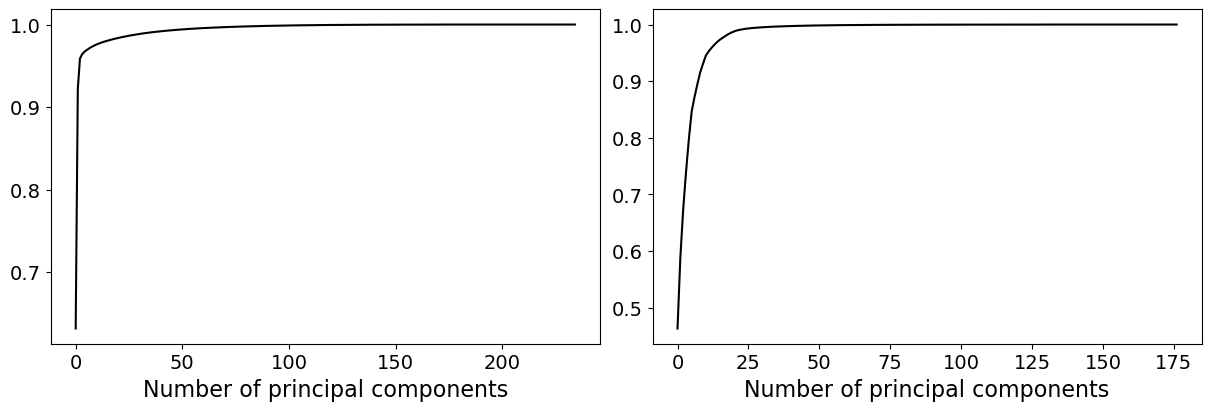

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
for _ax in axes:
    _ax.tick_params('both', labelsize=14)
    _ax.set_xlabel('Number of principal components', fontsize=16)
axes[0].plot(np.cumsum(bm_pca.explained_variance_ratio_), color='k')
axes[1].plot(np.cumsum(oc_pca.explained_variance_ratio_), color='k')
plt.savefig('pca_cev.png', dpi=100)

In [13]:
import tqdm
def get_evr(X):
    return PCA().fit(X).explained_variance_ratio_

n = tbifile.biomarkers.shape[0]
bm_evr_reps = list()
oc_evr_reps = list()
for i in tqdm.tqdm(range(1000)):
    bm_evr_reps.append(get_evr(tbifile.biomarkers[np.random.randint(0, n, n)]))
    oc_evr_reps.append(get_evr(tbifile.outcomes[np.random.randint(0, n, n)]))
bm_evr_reps = np.array(bm_evr_reps)
oc_evr_reps = np.array(oc_evr_reps)

100%|██████████| 1000/1000 [02:31<00:00,  6.59it/s]


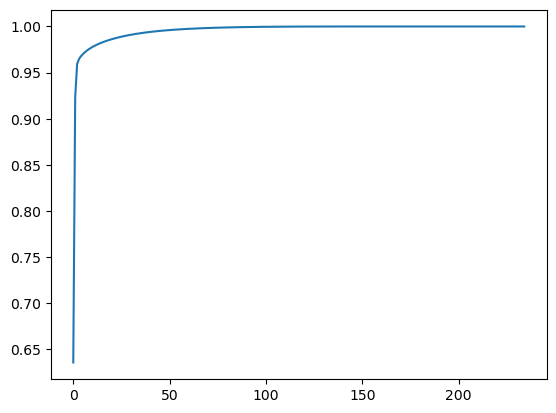

In [14]:
mean_evr = bm_evr_reps.mean(axis=0)
plt.plot(np.cumsum(mean_evr))

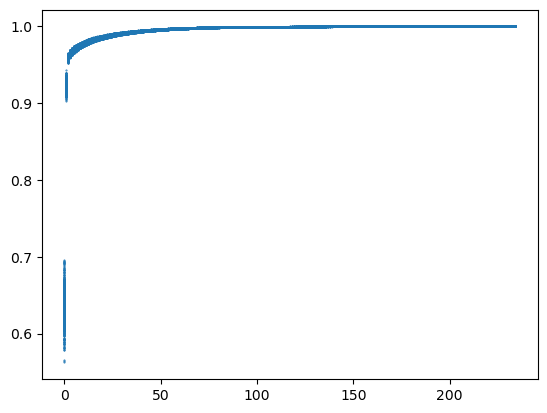

In [15]:
plt.scatter(np.tile(np.arange(bm_evr_reps.shape[1]), bm_evr_reps.shape[0]), np.cumsum(bm_evr_reps, axis=1).ravel(), s=0.2)

In [16]:
np.argmax(np.cumsum(bm_evr_reps, axis=1) > 0.95, axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [17]:
oc_est = np.argmax(np.cumsum(oc_evr_reps, axis=1) > 0.95, axis=1)
oc_mean = oc_est.mean()
oc_spread = 1.96 * np.sqrt(oc_est.var())
np.round(oc_mean - oc_spread), np.round(oc_mean + oc_spread)

(9.0, 12.0)

In [18]:
bm_est = np.argmax(np.cumsum(bm_evr_reps, axis=1) > 0.95, axis=1)
bm_mean = bm_est.mean()
bm_spread = 1.96 * np.sqrt(bm_est.var())
np.round(bm_mean - bm_spread), np.round(bm_mean + bm_spread)

(2.0, 2.0)

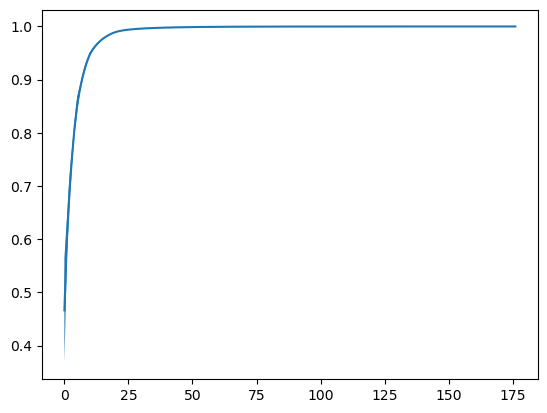

In [19]:
mean_evr = np.cumsum(oc_evr_reps, axis=1).mean(axis=0)
dev_evr = 1.96 * np.sqrt(oc_evr_reps.var(axis=0))
x = np.arange(mean_evr.shape[0])
plt.plot(x, mean_evr)
plt.fill_between(x, y1=mean_evr + dev_evr, y2=mean_evr - dev_evr)

In [33]:
oc_mean

10.681

In [20]:
from sklearn.decomposition import PCA
bm_pca = PCA().fit(tbifile.biomarkers)
oc_pca = PCA().fit(tbifile.outcomes)

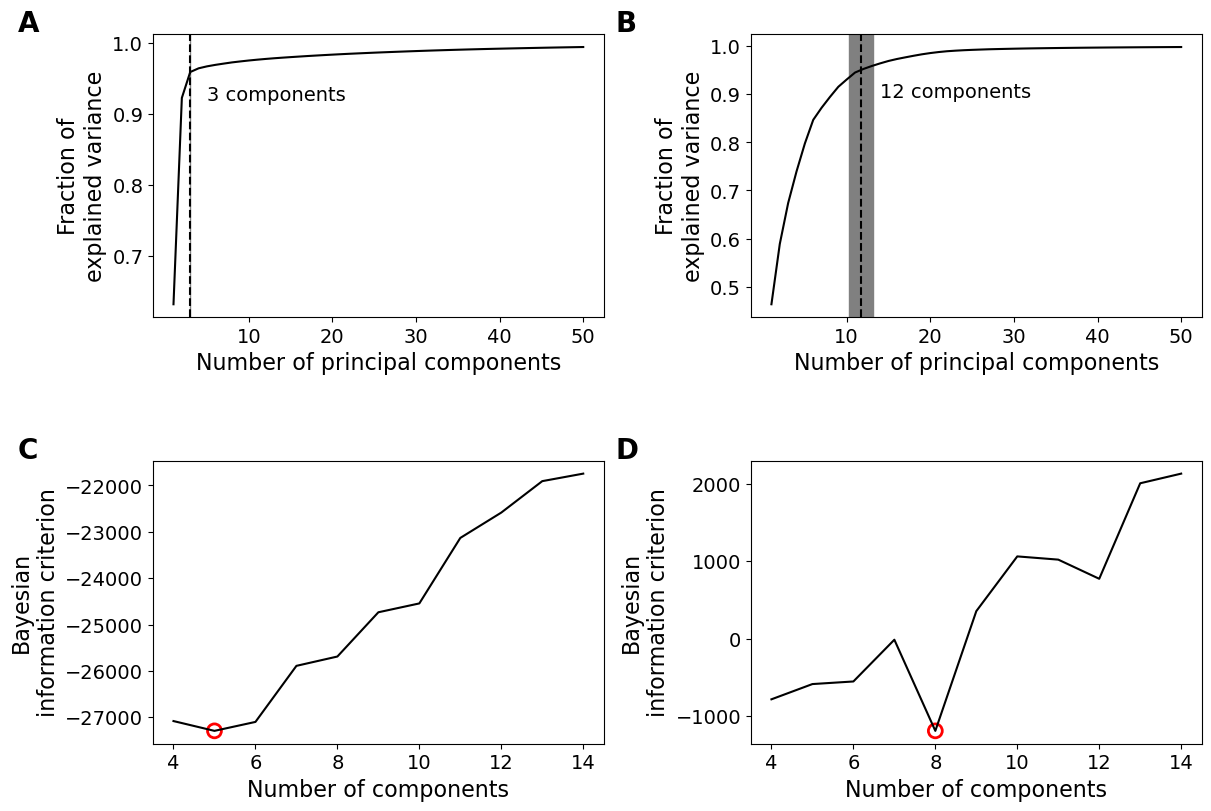

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)


def add_est(ax, mean, std, vline=True):
    ax.axvspan(mean - std, mean + std, color='gray')
    if vline:
        ax.axvline(mean, color='k', linestyle='--')
        
def add_arrow(ax, x, y, vline=False, text=None):
    mn, mx = ax.get_ylim()
    dy = 0.15 * (mx - mn)
    # ax.arrow(x, y+dy*1.1, 0, -dy, shape='full', width=)
    # ax.annotate("", xy=(x, y), xytext=(x, y+dy*1.1), arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
    ax.scatter(x, y, facecolor='none', color='red', s=100, linewidth=2)
    if vline:
        ax.axvline(x, color='gray', linestyle='--')
        
def add_ncomps(ax, x, y, vline=False, text=None):
    s, e = ax.get_ylim()
    shift = (e - s) * 0.1
    lbls = np.array([10, 20, 30, 40, 50])
    ax.set_xticks(lbls-1, labels=lbls)
    ax.text(x + 2, y - shift, f'{x+1} components', fontsize=14)
        
        
#plt.savefig('nmf_bic.png', dpi=100)
for _ax in axes[0]:
    _ax.tick_params('both', labelsize=14)
    _ax.set_xlabel('Number of principal components\n\n', fontsize=16)
    _ax.set_ylabel('Fraction of\nexplained variance', fontsize=16)
#########################

bm_ev = np.cumsum(bm_pca.explained_variance_ratio_)
oc_ev = np.cumsum(oc_pca.explained_variance_ratio_)
axes[0, 0].plot(bm_ev[:50], color='k')
axes[0, 1].plot(oc_ev[:50], color='k')




idx = int(np.round(bm_mean))
add_est(axes[0, 0], bm_mean, bm_spread, vline=True)
add_ncomps(axes[0, 0], idx, bm_ev[idx], vline=True)
idx = int(np.round(oc_mean))
add_est(axes[0, 1], oc_mean, oc_spread, vline=True)
add_ncomps(axes[0, 1], idx, oc_ev[idx], vline=True)


for _ax in axes[1]:
    _ax.tick_params('both', labelsize=14)
    _ax.set_xlabel('Number of components', fontsize=16)
    _ax.set_ylabel('Bayesian\ninformation criterion', fontsize=16)

axes[1, 0].plot(default_ranks, bm_results, c='k')
idx = np.argmin(bm_results)
#plt.title('Biomarkers, BIC, %d, %0.2f' % (default_ranks[idx], bm_results[idx]))
#axes[0].set_title('Biomarkers, BIC, %d' % (default_ranks[idx]), fontsize=16)

add_arrow(axes[1, 0], default_ranks[idx], bm_results[idx])


axes[1, 1].plot(default_ranks, oc_results, c='k')
idx = np.argmin(oc_results)
#plt.title('Outcome, BIC, %d, %0.2f' % (default_ranks[idx], oc_results[idx]))
#axes[1].set_title('Outcome, BIC, %d' % (default_ranks[idx]), fontsize=16)
axes[1, 1].set_xlabel('Number of components', fontsize=16)
add_arrow(axes[1, 1], default_ranks[idx], oc_results[idx])

def add_label(ax, label):
    ax.text(-0.3, 1.01, label, transform=ax.transAxes, weight='bold', size=20)    
    
for _ax, lbl in zip(axes.ravel(), 'ABCD'):
    add_label(_ax, lbl)

plt.savefig('../../paper/nmf_bic.pca_cev.bs.png', dpi=100)

# Original Figure

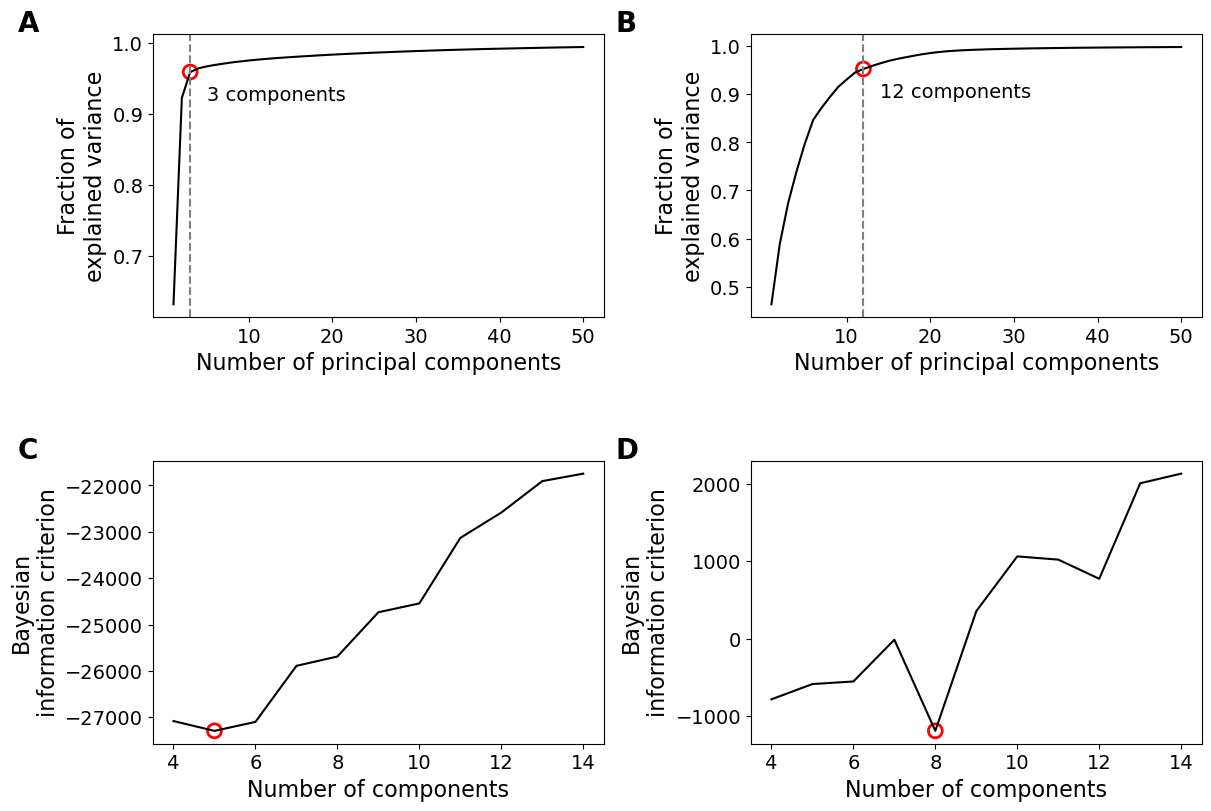

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)


def add_arrow(ax, x, y, vline=False, text=None):
    mn, mx = ax.get_ylim()
    dy = 0.15 * (mx - mn)
    # ax.arrow(x, y+dy*1.1, 0, -dy, shape='full', width=)
    # ax.annotate("", xy=(x, y), xytext=(x, y+dy*1.1), arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
    ax.scatter(x, y, facecolor='none', color='red', s=100, linewidth=2)
    if vline:
        ax.axvline(x, color='gray', linestyle='--')
        
def add_ncomps(ax, x, y, vline=False, text=None):
    s, e = ax.get_ylim()
    shift = (e - s) * 0.1
    lbls = np.array([10, 20, 30, 40, 50])
    ax.set_xticks(lbls-1, labels=lbls)
    ax.text(x + 2, y - shift, f'{x+1} components', fontsize=14)
        
        
#plt.savefig('nmf_bic.png', dpi=100)
for _ax in axes[0]:
    _ax.tick_params('both', labelsize=14)
    _ax.set_xlabel('Number of principal components\n\n', fontsize=16)
    _ax.set_ylabel('Fraction of\nexplained variance', fontsize=16)
#########################

bm_ev = np.cumsum(bm_pca.explained_variance_ratio_)
oc_ev = np.cumsum(oc_pca.explained_variance_ratio_)
axes[0, 0].plot(bm_ev[:50], color='k')
axes[0, 1].plot(oc_ev[:50], color='k')




idx = np.where(bm_ev > 0.95)[0][0]
add_arrow(axes[0, 0], idx, bm_ev[idx], vline=True)
add_ncomps(axes[0, 0], idx, bm_ev[idx], vline=True)
idx = np.where(oc_ev > 0.95)[0][0]
add_arrow(axes[0, 1], idx, oc_ev[idx], vline=True)
add_ncomps(axes[0, 1], idx, oc_ev[idx], vline=True)


for _ax in axes[1]:
    _ax.tick_params('both', labelsize=14)
    _ax.set_xlabel('Number of components', fontsize=16)
    _ax.set_ylabel('Bayesian\ninformation criterion', fontsize=16)

axes[1, 0].plot(default_ranks, bm_results, c='k')
idx = np.argmin(bm_results)
#plt.title('Biomarkers, BIC, %d, %0.2f' % (default_ranks[idx], bm_results[idx]))
#axes[0].set_title('Biomarkers, BIC, %d' % (default_ranks[idx]), fontsize=16)

add_arrow(axes[1, 0], default_ranks[idx], bm_results[idx])


axes[1, 1].plot(default_ranks, oc_results, c='k')
idx = np.argmin(oc_results)
#plt.title('Outcome, BIC, %d, %0.2f' % (default_ranks[idx], oc_results[idx]))
#axes[1].set_title('Outcome, BIC, %d' % (default_ranks[idx]), fontsize=16)
axes[1, 1].set_xlabel('Number of components', fontsize=16)
add_arrow(axes[1, 1], default_ranks[idx], oc_results[idx])

def add_label(ax, label):
    ax.text(-0.3, 1.01, label, transform=ax.transAxes, weight='bold', size=20)    
    
for _ax, lbl in zip(axes.ravel(), 'ABCD'):
    add_label(_ax, lbl)

plt.savefig('../../paper/nmf_bic.pca_cev.png', dpi=100)

# EXTRA

In [23]:
bm_results_recerr = tbi_gridsearch(minmax_scale(tbifile.biomarkers), scorer=recon_err)

Text(0.5, 1.0, 'Biomarkers, BIC, 14')

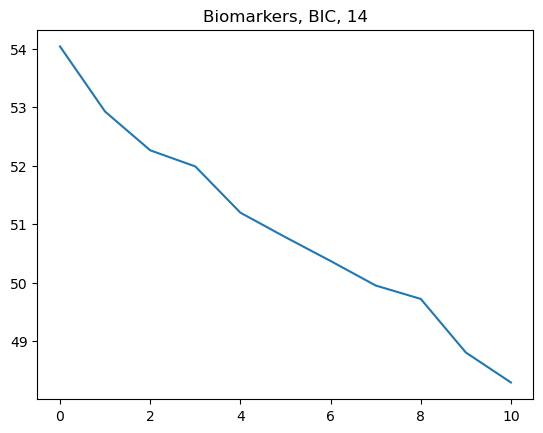

In [24]:
plt.plot(bm_results_recerr)
plt.title('Biomarkers, BIC, %d' % default_ranks[np.argmin(bm_results_recerr)])

In [25]:
oc_results_recerr = tbi_gridsearch(minmax_scale(tbifile.outcomes), scorer=recon_err)

Text(0.5, 1.0, 'Outcome, BIC, 14')

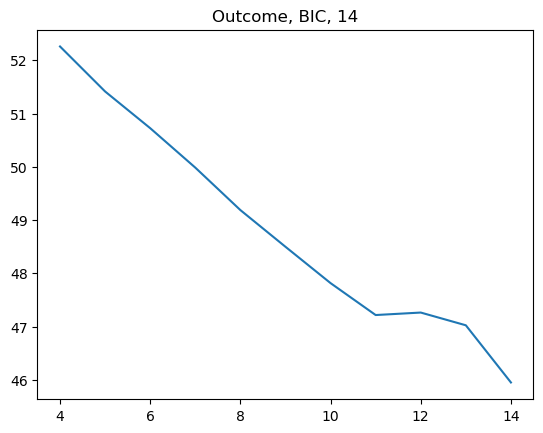

In [26]:
plt.plot(default_ranks, oc_results_recerr)
plt.title('Outcome, BIC, %d' % default_ranks[np.argmin(oc_results_recerr)])

In [27]:
from activ.cca.alscca import gs

def test_sim(X, n_splits=5, ranks=np.arange(4, 40)):
    cv = KFold()
    ret = np.zeros((cv.n_splits, ranks.shape[0]))
    for i, (train_idx, test_idx) in enumerate(cv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        for j, k in enumerate(ranks):
            nmf = NMF(n_components=k, solver='mu', beta_loss='kullback-leibler', init='random').fit(X_train)
            X_recon = nmf.inverse_transform(nmf.transform(X_test))
            ret[i, j] = np.linalg.norm(X_recon - X_test, ord='fro')
    return ret

H = np.random.random(size=(8, 200))
W = np.random.random(size=(300, 8))
X = W @ H

sim_results = test_sim(X)



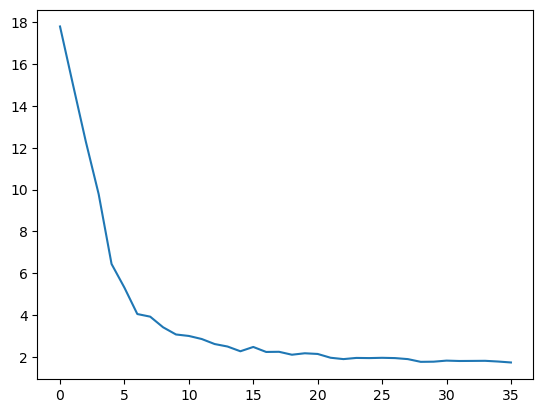

In [28]:
plt.plot(sim_results.mean(axis=0))

In [29]:
no_latent_results = test_sim(np.random.random(size=(300,200)))

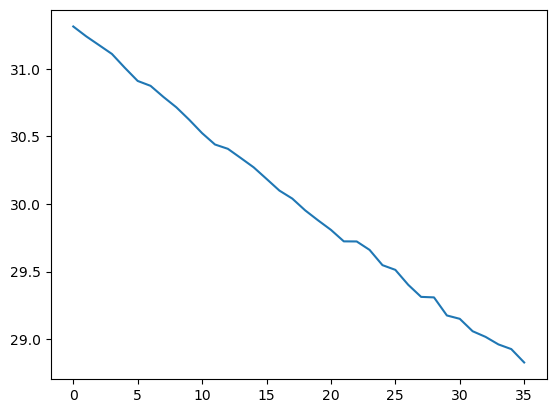

In [30]:
plt.plot(no_latent_results.mean(axis=0))

In [31]:
grid = dict(alpha=10.**(-1*np.arange(4)), l1_ratio=10.**(np.arange(5)-2), solver=['mu'], beta_loss=['kullback-leibler'], init=['random'],
            n_components=np.arange(4,13))
grid = ParameterGrid(grid)

In [32]:
results = gridsearch(tbifile.gcs_simple, minmax_scale(tbifile.biomarkers), grid=grid)

NameError: name 'gridsearch' is not defined

In [ ]:
plt.plot(results[0].mean(axis=0))

In [ ]:
scores = results[0].mean(axis=0).reshape((9, 4, 4))

plt.figure(figsize=(10, 10))
for i, k in enumerate(range(4, 13)):
    plt.subplot(3, 3, i+1)
    plt.imshow(scores[i], cmap='Greys')
    plt.title(f'k={k}')

In [ ]:
grid[np.argmin(results[0].mean(axis=0))]

In [ ]:
results[0].shape

In [ ]:
list(results[1])